# Модель предсказания срывов поставок на основе CatBoost

## Библиотеки и модули

Загрузка библиотек и модулей, используемых в решении. 
- Модель: **CatBoostClassifier** из библиотеки **CatBoost**
- Предобработчик данных для модели: **DataPreprocessor** (из модуля **helper.data**)
- Борьба с дисбалансом классов: **RandomOverSampler** (библиотека **imbalanced-learn**)
- Разделение на тренировочную и тестовую выборки, кросс-валидация, оценка решения: 
    - библиотека **scikit-learn**
    - **valid_predictions** (из модуля **helpers.validation**)
- Работа с датасетом: библиотека **pandas**
- Работа с файловой системой: модуль **os**

In [1]:
# Модель
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Пайплайн
from sklearn.pipeline import Pipeline
from helpers.data import DataPreprocessor, CAT_FEATURES
from helpers.validation import valid_predictions

# Данные
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Проверка GPU
from catboost.utils import get_gpu_device_count
TASK_TYPE = 'GPU' if get_gpu_device_count() else 'CPU'

# Настройки вывода
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Загрузка датасетов

In [2]:
# Пути
ROOT = os.getcwd()
TRAIN_DATASET = os.path.join(ROOT, '../data/train_AIC.csv')
BALANCED_DATASET = os.path.join(ROOT, '../data/balanced_train.csv')
TEST_DATASET = os.path.join(ROOT, '../data/test_AIC.csv')
SUBMISSION_PATH = os.path.join(ROOT, '../submissions/')

# Функции
def make_predictions(model: object | Pipeline, X_test: pd.DataFrame) -> None:
    """ Функция создания предсказаний для тестовой выборки.
    
    Обучает переданную модель на сбалансированном датасете, учитывая выбросы.
    Предсказания сохраняются с помощью функции save_submission.
    
    Параметры:
        model: Модель или пайплайн, используемый для обучения и предсказания меток
            тестовой выборки.
        X_test: Тестовая выборка, для которой будут сделаны предсказания.
            Экземпляр pandas.DataFrame."""
    
    # Загрузка сбалансированного датасета
    balanced_df = pd.read_csv(BALANCED_DATASET, index_col=0)
    
    # Обрезка негативных записей до числа позитивных
    first_negatives = balanced_df[balanced_df['y'] == 0][:balanced_df[balanced_df['y'] == 1]['y'].count()]
    balanced_df = pd.concat([balanced_df[balanced_df['y'] == 1], first_negatives])

    # Удаление выбросов
    balanced_df = balanced_df[balanced_df['Длительность'] < 400]
    balanced_df = balanced_df[(balanced_df['Сумма'] > 2) & (balanced_df['Сумма'] < 10)]
    balanced_df = balanced_df[balanced_df['До поставки'] < 300]
    balanced_df = balanced_df[balanced_df['Дней между 0_1'] < 400]
    balanced_df = balanced_df[balanced_df['Количество изменений после согласований'] < 2000]
    balanced_df = balanced_df[balanced_df['Количество'] < 300000]
    
    # Разделение независимых и независимых переменных
    X, y = balanced_df.iloc[:, :-1], balanced_df.iloc[:, -1]   

    # Обучение модели и создание предсказаний для тестовой выборки
    model.fit(X, y)
    preds = model.predict(X_test)

    # Сохранение предсказаний
    save_submission(preds, 'submission')
    
def save_submission(preds: list | pd.DataFrame | pd.arrays.PandasArray, subname: str) -> None:
    subname = os.path.join(SUBMISSION_PATH, f'{subname}.csv')
    submit_df = pd.DataFrame({'id': test_df.index, 'value': preds})
    submit_df.to_csv(subname, index=False)


# Загрузка датасетов
train_df = pd.read_csv(TRAIN_DATASET)
test_df = pd.read_csv(TEST_DATASET)

# Удаление дубликатов из тренировочной выборки
train_df = train_df.drop_duplicates()

# Разделение выборки на тренировочную и тестовую
X, y = train_df.iloc[:, :-1], train_df.iloc[:, -1]   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Удаление выбросов из тренировочной выборки
X_train = pd.concat([X_train, y_train], axis=1) # Объединяем X_train и y_train
X_train = X_train[X_train['Длительность'] < 400]
X_train = X_train[(X_train['Сумма'] > 2) & (X_train['Сумма'] < 10)]
X_train = X_train[X_train['До поставки'] < 300]
X_train = X_train[X_train['Дней между 0_1'] < 400]
X_train = X_train[X_train['Количество изменений после согласований'] < 2000]
X_train = X_train[X_train['Количество'] < 300000]

# Отделяем метки классов от признаков
y_train = X_train['y']
X_train = X_train.drop('y', axis=1)

# Общий датасет для большего числа записей, используемых на кросс-валидации
X_general, y_general = train_df.iloc[:, :-1], train_df.iloc[:, -1]

## Тестирование модели

### Создание пайплайна

- Кросс-валидация: используется X_general и y_general, не содержащие дубликатов.
- Валидация на тестовой выборке (X_test, y_test): используется X_res и y_res, полученные с помощью рандомного оверсемплирования X_train и y_train.
- Модель: CatBoostClassifier из библиотеки CatBoost
- Параметры модели: подобраны с учётом результатов подбора гиперпараметров, а также ручных корректировок для повышения обобщающей способности.
- Пайплайн:
    - Предобработчик: кастомный предобработчик DataPreproccessor из модуля helper.data, совмещающий BinaryEncoder, RobustScaler, экстракцию признаков.
    - Модель: CatBoostClassifier

In [6]:
# Создание оверсемпл-датасета (отбор рандомных записей)
oversampler = RandomOverSampler(random_state=42)
X_res, y_res = oversampler.fit_resample(X_train, y_train)

# Параметры
parameters = {
    'cat_features': CAT_FEATURES,
    'learning_rate': 0.2,
    'iterations': 1500, 
    'max_depth': 12,
    'l2_leaf_reg': 0.2,
    'task_type': TASK_TYPE,
    }

# Предобработчик и модель
data_preprocessor = DataPreprocessor(encode_categorical=False)
model = CatBoostClassifier(**parameters, eval_metric='F1')

# Пайплайн
pipeline = Pipeline([('data_preproc', data_preprocessor),
                     ('model', model)])

### Кросс-валидация
- Для кроссвалидации используется алгоритм Stratified K-Fold, учитывающий распределение классов. 
- Число используемых фолдов: 5.
- Метрика: F1-macro

In [ ]:
# Запуск кросс-валидации
cv_scores = cross_val_score(pipeline, X_general, y_general, cv=StratifiedKFold(n_splits=5), scoring='f1_macro')
print(f'Mean CV: {cv_scores.mean()}')

### Валидация на тестовой выборке

In [7]:
# Обучение модели и получение предсказаний для тестовой выборки
try:
    pipeline.fit(X_res, y_res)
    preds = pipeline.predict(X_test)
except Exception as _ex:
    print('Возможно GPU не хватило памяти или он недоступен, TASK_TYPE будет изменён на CPU')
    print(_ex)

    # Повторная попытка
    pipeline['model'].set_params({'task_type': 'CPU'})
    pipeline.fit(X_res, y_res)
    preds = pipeline.predict(X_test)

0:	learn: 0.8845452	total: 354ms	remaining: 8m 50s
1:	learn: 0.8889923	total: 682ms	remaining: 8m 30s
2:	learn: 0.8915375	total: 988ms	remaining: 8m 12s
3:	learn: 0.8952253	total: 1.32s	remaining: 8m 15s
4:	learn: 0.8970646	total: 1.64s	remaining: 8m 11s
5:	learn: 0.9015046	total: 1.97s	remaining: 8m 11s
6:	learn: 0.9062544	total: 2.31s	remaining: 8m 13s
7:	learn: 0.9120737	total: 2.63s	remaining: 8m 10s
8:	learn: 0.9156842	total: 2.94s	remaining: 8m 7s
9:	learn: 0.9173486	total: 3.25s	remaining: 8m 4s
10:	learn: 0.9220053	total: 3.57s	remaining: 8m 3s
11:	learn: 0.9238764	total: 3.91s	remaining: 8m 4s
12:	learn: 0.9259793	total: 4.24s	remaining: 8m 4s
13:	learn: 0.9276265	total: 4.55s	remaining: 8m 2s
14:	learn: 0.9300299	total: 4.88s	remaining: 8m 2s
15:	learn: 0.9316883	total: 5.2s	remaining: 8m 2s
16:	learn: 0.9331808	total: 5.53s	remaining: 8m 2s
17:	learn: 0.9352973	total: 5.83s	remaining: 8m
18:	learn: 0.9381554	total: 6.18s	remaining: 8m 1s
19:	learn: 0.9403060	total: 6.51s	rem

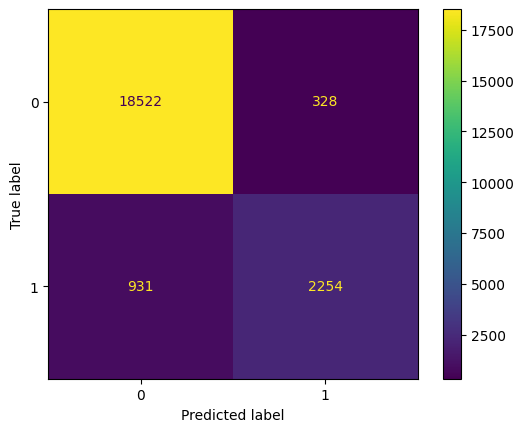

              precision    recall  f1-score   support

           0    0.95214   0.98260   0.96713     18850
           1    0.87297   0.70769   0.78169      3185

    accuracy                        0.94286     22035
   macro avg    0.91255   0.84515   0.87441     22035
weighted avg    0.94070   0.94286   0.94033     22035

F1-macro: 0.8744097158429824
ROC-AUC score: 0.8451458885941645
Accuracy: 0.9428636260494667


In [8]:
# Вывод результатов валидации
valid_predictions(y_test, preds, pipeline.classes_)

## Получение предсказаний для AI Challenge

In [ ]:
# Предсказание для тестовой выборки AI Challenge
make_predictions(pipeline, test_df)